In [6]:
!pip install torchvision

   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.3 MB ? eta -:--:--
   --------- ------------------------------ 1.0/4.3 MB 3.9 MB/s eta 0:00:01
   ----------------- ---------------------- 1.8/4.3 MB 3.9 MB/s eta 0:00:01
   ------------------------ --------------- 2.6/4.3 MB 3.9 MB/s eta 0:00:01
   ------------------------------- -------- 3.4/4.3 MB 3.9 MB/s eta 0:00:01
   -------------------------------------- - 4.2/4.3 MB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 4.3/4.3 MB 3.8 MB/s  0:00:01


In [7]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import random
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

random.seed(41)
DATA_DIR = r"Datasets/train"

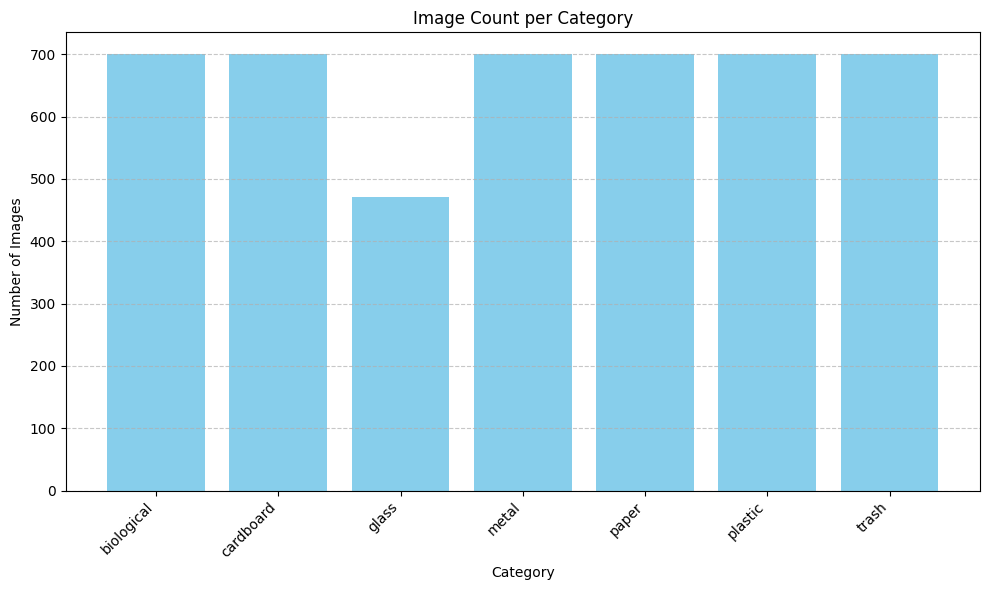

In [8]:
categories = []
image_counts = []

for category in os.listdir(DATA_DIR):
    category_path = os.path.join(DATA_DIR, category)
    
    if not os.path.isdir(category_path):
        continue
    
    num_images = len(
        [
            f
            for f in os.listdir(category_path)
            if os.path.isfile(os.path.join(category_path, f))
        ]
    )
    
    categories.append(category)
    image_counts.append(num_images)

plt.figure(figsize=(10, 6))
plt.bar(categories, image_counts, color='skyblue')

plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Image Count per Category')

plt.xticks(rotation=45, ha='right') 

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

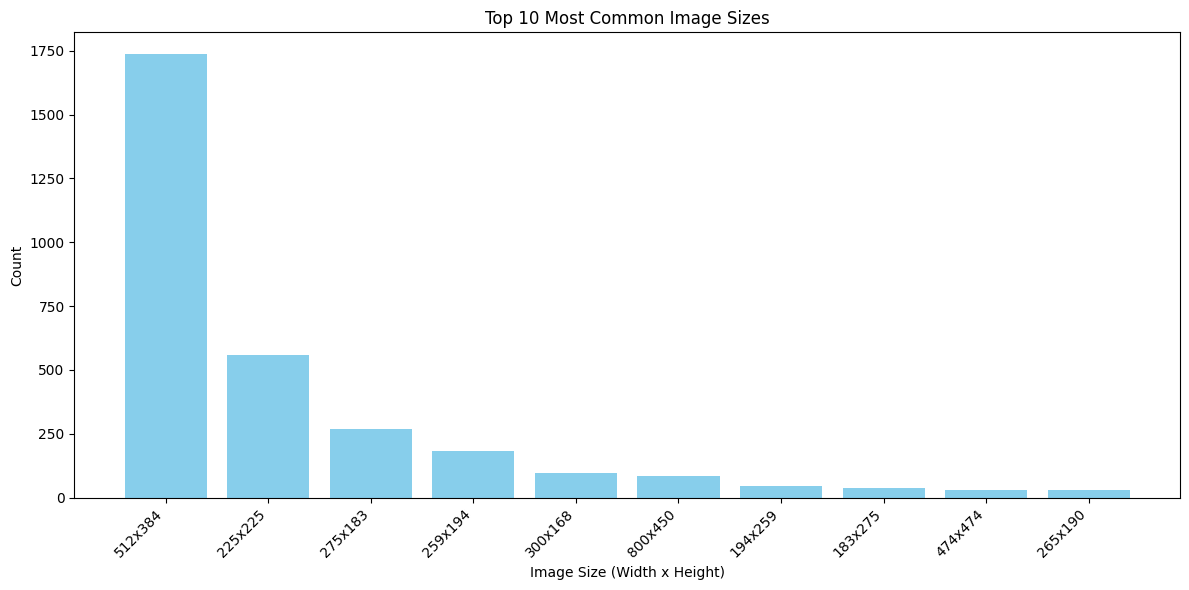

In [ ]:
sizes = []
formats = []

for category in os.listdir(DATA_DIR):
    category_path = os.path.join(DATA_DIR, category)
    if not os.path.isdir(category_path):
        continue

    for f in os.listdir(category_path):
        img_path = os.path.join(category_path, f)
        if not os.path.isfile(img_path):
            continue

        try:
            with Image.open(img_path) as img:
                sizes.append(img.size)
                formats.append(img.format)
        except Exception as e:
            print(f"Error reading {img_path}: {e}")

size_counts = Counter(sizes).most_common(10)

size_labels = [f"{w}x{h}" for (w, h), count in size_counts]
size_values = [count for (w, h), count in size_counts]

plt.figure(figsize=(12, 6))
plt.bar(size_labels, size_values, color="skyblue")
plt.xlabel("Image Size (Width x Height)")
plt.ylabel("Count")
plt.title("Top 10 Most Common Image Sizes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

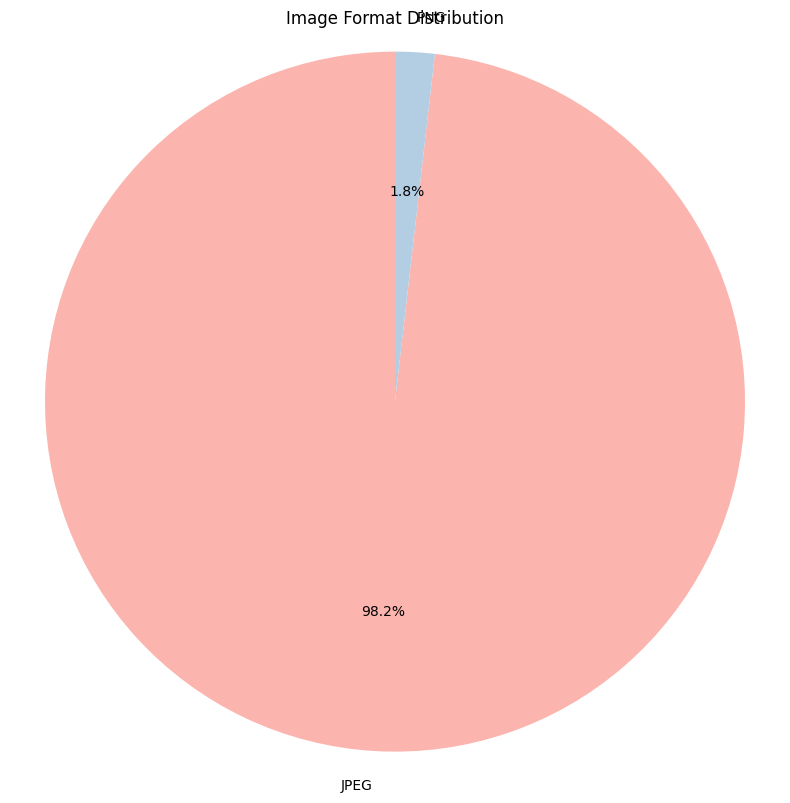

In [ ]:
format_counts = Counter(formats)

format_labels = list(format_counts.keys())
format_values = list(format_counts.values())

plt.figure(figsize=(8, 8))
plt.pie(
    format_values,
    labels=format_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=plt.cm.Pastel1.colors,
)
plt.title("Image Format Distribution")
plt.axis("equal")
plt.tight_layout()
plt.show()

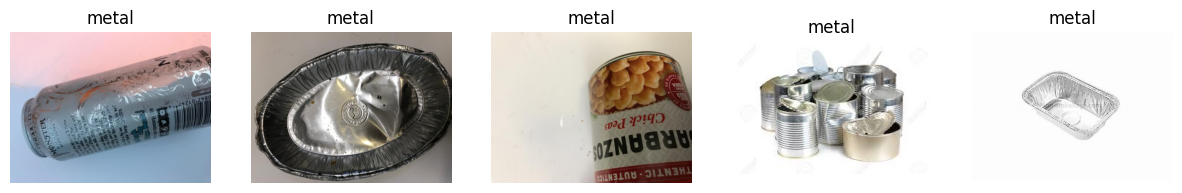

In [ ]:
category = random.choice(os.listdir(DATA_DIR))
category_path = os.path.join(DATA_DIR, category)
images = [
    f
    for f in os.listdir(category_path)
    if os.path.isfile(os.path.join(category_path, f))
]

plt.figure(figsize=(15, 5))
for i, img_file in enumerate(random.sample(images, min(5, len(images)))):
    img_path = os.path.join(category_path, img_file)
    img = Image.open(img_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(category)
plt.show()

In [9]:
class ResizeWithPadding:
    def __init__(self, target_size):
        self.target_size = target_size  # (width, height)

    def __call__(self, img):
        # Get original size
        w, h = img.size
        target_w, target_h = self.target_size

        # Calculate scale to fit inside target
        scale = min(target_w / w, target_h / h)
        new_w = int(w * scale)
        new_h = int(h * scale)

        # Resize image
        img_resized = img.resize((new_w, new_h), Image.BILINEAR)

        # Create new image and paste the resized image centered
        new_img = Image.new("RGB", self.target_size, (0, 0, 0))  # black padding
        paste_x = (target_w - new_w) // 2
        paste_y = (target_h - new_h) // 2
        new_img.paste(img_resized, (paste_x, paste_y))

        return new_img

In [10]:
target_size = (224, 224)  # width, height

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]


# Training transforms with data augmentation
train_transforms = transforms.Compose(
    [
        ResizeWithPadding(target_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

# Validation/Test transforms (no augmentation)
val_test_transforms = transforms.Compose(
    [
        ResizeWithPadding(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

In [11]:
for split in ["train", "val", "test"]:
    split_path = os.path.join(DATA_DIR, split)
    for category in os.listdir(split_path):
        category_path = os.path.join(split_path, category)
        for file in os.listdir(category_path):
            file_path = os.path.join(category_path, file)
            with Image.open(file_path) as img:
                # Convert to RGB and save as JPEG
                rgb_img = img.convert("RGB")
                new_path = os.path.splitext(file_path)[0] + ".jpg"
                rgb_img.save(new_path, "JPEG")
                if new_path != file_path:
                    os.remove(file_path)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Datasets/train\\train'

In [12]:
train_dataset = ImageFolder(
    root=r"Datasets/train", transform=train_transforms
)
val_dataset = ImageFolder(root=r"Datasets/val", transform=val_test_transforms)
test_dataset = ImageFolder(root=r"Datasets/test", transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 4671
Number of validation samples: 1001
Number of test samples: 1002


In [13]:
# Function to check sizes of transformed images
def check_image_sizes(dataset, sample_count=100):
    sizes = []
    for i, (img, label) in enumerate(dataset):
        # img is a tensor: shape [C, H, W]
        _, h, w = img.shape
        sizes.append((w, h))
        if i + 1 >= sample_count:
            break
    return sizes


# Check first 100 images from each dataset
train_sizes = check_image_sizes(train_dataset)
val_sizes = check_image_sizes(val_dataset)
test_sizes = check_image_sizes(test_dataset)

print("Train image sizes (sample 100):", train_sizes[:10])
print("Validation image sizes (sample 100):", val_sizes[:10])
print("Test image sizes (sample 100):", test_sizes[:10])

Train image sizes (sample 100): [(224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224)]
Validation image sizes (sample 100): [(224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224)]
Test image sizes (sample 100): [(224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224)]


In [14]:
import torch
import torch.nn as nn
from torchvision.models import vit_b_16, ViT_B_16_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_classes = len(train_dataset.classes)

weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)

in_features = model.heads.head.in_features
model.heads.head = nn.Linear(in_features, num_classes)

model = model.to(device)


Using device: cpu
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\ziad1/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth


100.0%


In [15]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [16]:
num_epochs = 10 

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(
        f"Epoch [{epoch}/{num_epochs}] "
        f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
        f"- Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )


Epoch [1/10] - Train Loss: 0.4299, Train Acc: 0.8576 - Val Loss: 0.2416, Val Acc: 0.9161
Epoch [2/10] - Train Loss: 0.1800, Train Acc: 0.9403 - Val Loss: 0.2649, Val Acc: 0.9171
Epoch [3/10] - Train Loss: 0.1251, Train Acc: 0.9572 - Val Loss: 0.1830, Val Acc: 0.9391


KeyboardInterrupt: 